# Appendix A: Lecture 09 

In [17]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(".."), "code"))

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import ConfusionMatrixDisplay  # Recommended method in sklearn 1.0


%matplotlib inline
pd.set_option("display.max_colwidth", 200)

from IPython.display import Image
pd.set_option("display.max_colwidth", 200)
DATA_DIR = "../data/"

## Macro average and weighted average

**Macro average**
- Gives equal importance to all classes and average over all classes.  
- For instance, in the example above, recall for non-fraud is 1.0 and fraud is 0.63, and so macro average is 0.81. 
- More relevant in case of multi-class problems.    

**Weighted average**

- Weighted by the number of samples in each class. 
- Divide by the total number of samples. 

Which one is relevant when depends upon whether you think each class should have the same weight or each sample should have the same weight. 

**Toy example**

In [26]:
from sklearn.metrics import classification_report
y_true_toy = [0, 1, 0, 1, 0]
y_pred_toy = [0, 0, 0, 1, 0]
target_names_toy = ['class 0', 'class 1']
print(classification_report(y_true_toy, y_pred_toy, target_names=target_names_toy))

              precision    recall  f1-score   support

     class 0       0.75      1.00      0.86         3
     class 1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



- weighted average is weighted by the proportion of examples in a particular class. So for the toy example above:
- weighted_average precision: 3/5 * 0.75 + 2/5 * 1.00 = 0.85
- weighted_average recall: 3/5 * 1.00 + 2/5 * 0.5 = 0.80
- weighted_average f1-score: 3/5 * 0.86 + 2/5 * 0.67 = 0.78

- macro average gives equal weight to both classes. So for the toy example above:
- macro average precision: 0.5 * 0.75 + 0.5 * 1.00 =0. 875
- macro average recall: 0.5 * 1.00 + 0.5 * 0.5 =0. 75
- macro average f1-score: 0.5 * 0.75 + 0.5 * 1.00 =0.765

<br><br><br>

## Evaluation metrics for multi-class classification 

Let's examine precision, recall, and f1-score of different classes in the [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus.

In [18]:
df = pd.read_csv(DATA_DIR+"cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)
sample_df.head()

,wid,reflection_period,original_hm,moment,modified,num_sentence,target,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed after a long time.,My grandmother start to walk from the bed after a long time.,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding


In [19]:
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
X_train_happy, y_train_happy = train_df["moment"], train_df["target"]
X_test_happy, y_test_happy = test_df["moment"], test_df["target"]

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

pipe_lr = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression(max_iter=2000)
)

In [21]:
pipe_lr.fit(X_train_happy, y_train_happy)
pred = pipe_lr.predict(X_test_happy)

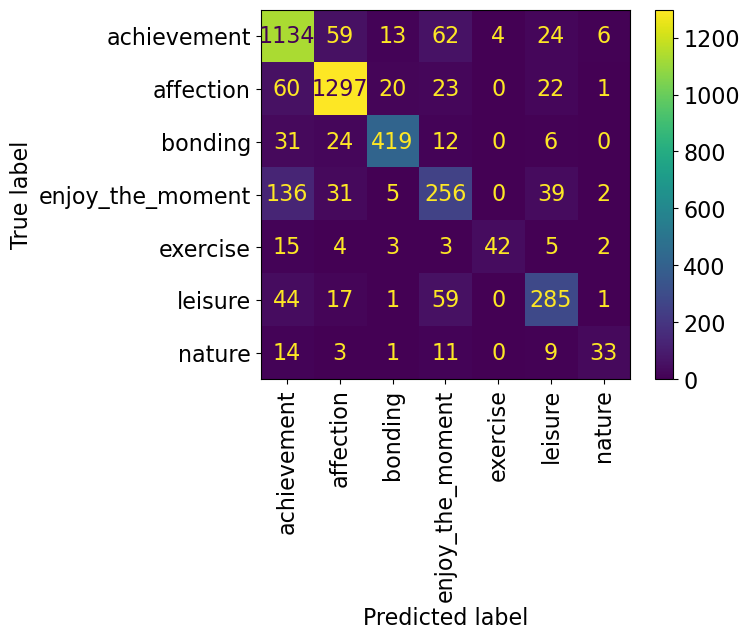

In [22]:
ConfusionMatrixDisplay.from_estimator(
    pipe_lr, X_test_happy, y_test_happy, xticks_rotation="vertical"
);

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test_happy, pred))

                  precision    recall  f1-score   support

     achievement       0.79      0.87      0.83      1302
       affection       0.90      0.91      0.91      1423
         bonding       0.91      0.85      0.88       492
enjoy_the_moment       0.60      0.55      0.57       469
        exercise       0.91      0.57      0.70        74
         leisure       0.73      0.70      0.72       407
          nature       0.73      0.46      0.57        71

        accuracy                           0.82      4238
       macro avg       0.80      0.70      0.74      4238
    weighted avg       0.82      0.82      0.82      4238



- Seems like there is a lot of variation in the scores for different classes. The model is performing pretty well on _affection_ class but not that well on _enjoy_the_moment_ and _nature_ classes.  
- If each class is equally important for you, pick macro avg as your evaluation metric.
- If each example is equally important, pick weighted avg as your metric. 

## Handling class imbalance by changing the data

- Undersampling
- Oversampling 
   - Random oversampling
   - SMOTE 

We cannot use sklearn pipelines because of some API related problems. But there is something called [`imbalance learn`](https://imbalanced-learn.org/stable/), which is an extension of the `scikit-learn` API that allows us to resample. It's already in our course environment. If you don't have the course environment installed, you can install it in your environment with this command: 

`conda install -c conda-forge imbalanced-learn`

### Data

In [25]:
# This dataset will be loaded using a URL instead of a CSV file
DATA_URL = "https://github.com/firasm/bits/raw/refs/heads/master/creditcard.csv"

cc_df = pd.read_csv(DATA_URL, encoding="latin-1")
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)
train_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
64454,51150.0,-3.538816,3.481893,-1.827130,-0.573050,2.644106,-0.340988,2.102135,-2.939006,2.578654,...,0.530978,-0.860677,-0.201810,-1.719747,0.729143,-0.547993,-0.023636,-0.454966,1.00,0
37906,39163.0,-0.363913,0.853399,1.648195,1.118934,0.100882,0.423852,0.472790,-0.972440,0.033833,...,0.687055,-0.094586,0.121531,0.146830,-0.944092,-0.558564,-0.186814,-0.257103,18.49,0
79378,57994.0,1.193021,-0.136714,0.622612,0.780864,-0.823511,-0.706444,-0.206073,-0.016918,0.781531,...,-0.310405,-0.842028,0.085477,0.366005,0.254443,0.290002,-0.036764,0.015039,23.74,0
245686,152859.0,1.604032,-0.808208,-1.594982,0.200475,0.502985,0.832370,-0.034071,0.234040,0.550616,...,0.519029,1.429217,-0.139322,-1.293663,0.037785,0.061206,0.005387,-0.057296,156.52,0
60943,49575.0,-2.669614,-2.734385,0.662450,-0.059077,3.346850,-2.549682,-1.430571,-0.118450,0.469383,...,-0.228329,-0.370643,-0.211544,-0.300837,-1.174590,0.573818,0.388023,0.161782,57.50,0


In [26]:
X_train_big, y_train_big = train_df.drop(columns=["Class", "Time"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class", "Time"]), test_df["Class"]

- It's easier to demonstrate evaluation metrics using an explicit validation set instead of using cross-validation. 
- So let's create a validation set. 
- Our data is large enough so it shouldn't be a problem. 


In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_big, y_train_big, test_size=0.3, random_state=123
)

### Undersampling

In [28]:
import imblearn
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train_subsample, y_train_subsample = rus.fit_resample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(139554, 29)
(474, 29)
[237 237]


In [29]:
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2,
    class_sep=2,
    weights=[0.1, 0.9],
    n_informative=3,
    n_redundant=1,
    flip_y=0,
    n_features=20,
    n_clusters_per_class=1,
    n_samples=1000,
    random_state=10,
)
print("Original dataset shape %s" % Counter(y))
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print("Resampled dataset shape %s" % Counter(y_res))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({0: 100, 1: 100})


In [30]:
undersample_pipe = make_imb_pipeline(
    RandomUnderSampler(), StandardScaler(), LogisticRegression()
)
scores = cross_validate(
    undersample_pipe, X_train, y_train, scoring=("roc_auc", "average_precision")
)
pd.DataFrame(scores).mean()

fit_time                  0.033706
score_time                0.015633
test_roc_auc              0.966393
test_average_precision    0.358614
dtype: float64

<br><br>

### Oversampling 

- Random oversampling with replacement 
- SMOTE: Synthetic Minority Over-sampling Technique

In [31]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_resample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(139554, 29)
(278634, 29)
[139317 139317]


In [32]:
oversample_pipe = make_imb_pipeline(
    RandomOverSampler(), StandardScaler(), LogisticRegression(max_iter=1000)
)
scores = cross_validate(
    oversample_pipe, X_train, y_train, scoring=("roc_auc", "average_precision")
)
pd.DataFrame(scores).mean()

fit_time                  0.932375
score_time                0.022678
test_roc_auc              0.961583
test_average_precision    0.713677
dtype: float64

<br><br>

#### [SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/pdf/1106.1813.pdf)

[sklearn SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html)

- Create "synthetic" examples rather than by over-sampling with replacement.
- Inspired by a technique of data augmentation that proved successful in handwritten character recognition. 
- The minority class is over-sampled by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the $k$ minority class nearest neighbors.
- $k$ is chosen depending upon the amount of over-sampling required.

#### SMOTE idea 

- Take the difference between the feature vector (sample) under consideration and its nearest neighbor. 
- Multiply this difference by a random number between 0 and 1, and add it to the feature vector under consideration. 
- This causes the selection of a random point along the line segment between two specific features. 
- This approach effectively forces the decision region of the minority class to become more general.

![](../img/SMOTE_doccam.png)

<!-- <img src="img/SMOTE_doccam.png" width="600" height="600"> -->

### Using SMOTE

- You need to [`imbalanced-learn`](https://imbalanced-learn.org/stable/index.html)
> class imblearn.over_sampling.SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=5, m_neighbors='deprecated', out_step='deprecated', kind='deprecated', svm_estimator='deprecated', n_jobs=1, ratio=None)

> Class to perform over-sampling using SMOTE.

> This object is an implementation of SMOTE - Synthetic Minority Over-sampling Technique as presented in [this paper](https://arxiv.org/pdf/1106.1813.pdf).

In [33]:
from imblearn.over_sampling import SMOTE

smote_pipe = make_imb_pipeline(
    SMOTE(), StandardScaler(), LogisticRegression(max_iter=1000)
)
scores = cross_validate(
    smote_pipe, X_train, y_train, cv=10, scoring=("roc_auc", "average_precision")
)
pd.DataFrame(scores).mean()

fit_time                  1.202060
score_time                0.012149
test_roc_auc              0.963030
test_average_precision    0.736545
dtype: float64

- We got higher average precision score with SMOTE in this case. 

- These are rather simple approaches to tackle class imbalance. 
- If you have a problem such as fraud detection problem where you want to spot rare events, you can think of this problem as anomaly detection problem and use algorithms such as isolation forests.
- If you are interested in this area, it might be worth checking out this book on this topic. (I've not read it.) 
    - Imbalanced Learning: Foundations, Algorithms, and Applications
    - It's available via UBC library.